<a href="https://colab.research.google.com/github/arva29/InformationRetrievalProject/blob/main/BoardGameComplexityPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DECIDERE COSA SCRIVERE

## **Importing dataset**

In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

In [24]:
df = pd.read_csv(io.BytesIO(uploaded['boardgames_dataset.csv']))
df.drop(df[df['weight'] == 0].index, inplace = True)
df

,Unnamed: 0,id,name,year,publisher,weight,rules
0,0,367525,3000 SCOUNDRELS,2022,UNEXPECTED GAMES,2.1667,"setup before your first game, place all clear ..."
1,1,154173,7 RONIN,2013,GREY FOX GAMES,2.2105,setup choose or determine randomly who is the ...
2,2,68448,7 WONDERS,2010,ASMODEE,2.3213,"setup depending on the number of players, retu..."
3,3,141517,A STUDY IN EMERALD,2013,TREEFROG GAMES,3.4538,setup shuffle the secret identity cards and de...
5,5,253499,A WAR OF WHISPERS,2020,STARLING GAMES,2.5500,setup each player chooses a matching player bo...
...,...,...,...,...,...,...,...
332,345,146451,WRATH OF KINGS,2014,COOL MINI OR NOT,2.9000,basics distances (in inches) may be measured a...
333,347,8593,WRECKAGE,2003,FANTASY FLIGHT GAMES,1.7222,setup 1. starting with a randomly chosen first...
334,348,38868,ZANZIAR,2009,DRAGON DAWN PRODUCTIONS,3.5625,setup each player takes: 3 pairs of adventurin...
335,349,2471,ZOMBIES!!!,2001,"TWILIGHT CREATIONS, INC.",1.6147,setup place the town square tile in the centre...


## **Metrics**

I this section the texts of the rulebooks are used to compute some metrics

### Gunning Fog Index

In linguistics, the Gunning fog index is a readability test for English writing. The index estimates the years of formal education a person needs to understand the text on the first reading. 
The index is calculated as:

\begin{align}
  0.4 \left[ \left(\frac{words}{sentences} \right) + 100 \left(\frac{complex words}{words} \right) \right]
\end{align}

In [3]:
!pip install hyphenator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for hyphenator: filename=hyphenator-0.6.0-py3-none-any.whl size=5074 sha256=035fe73c22544880af177664c1a809c5c7421a1c3fdfa07ae2303130d292de53
  Stored in directory: /root/.cache/pip/wheels/19/af/80/1de26d742b06c2954743f0ced22e5b49443ac9ecd5569df190
Successfully built hyphenator


Importing the .dic file needed to divide words in syllables. The file used is the one provided by the LibreOfffice Foundation and it could be found at this [link](https://github.com/LibreOffice/dictionaries/blob/master/en/hyph_en_US.dic)

In [5]:
from hyphenator import Hyphenator

dic = files.upload()
h = Hyphenator("/content/hyph_en_US.dic")

#Given a word return the number of syllables
def count_syllables(word):
    return 1 + h.inserted(word).count('-')

In [25]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from string import punctuation
import nltk
nltk.download('punkt')

#Given a text return the Gunning Fog Index
def gunning_fox_index(text):
    gfi = 0
    complex_words = 0
    sentences = len(sent_tokenize(text))
    tokens = [x for x in word_tokenize(text) if x not in punctuation]
    words = len(tokens)
    
    for token in tokens:
        if count_syllables(token) >= 3:
            complex_words += 1
    
    #Gunning Fog Index formula
    gfi = 0.4 * (words / sentences + 100 * complex_words / words)
        
    return gfi


#Compute the GFI for all the record in the dataframe and add the results as new column
gfi_array = list()

for r in df["rules"]:
    gfi_array.append(gunning_fox_index(r))
    
df["gfi"] = gfi_array

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Number of words analisys

#### Number of Words

Simply counting the number of words, that are not stopwords, in each texts.

In [26]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopw = set(stopwords.words('english'))

#Count the number of words, that are not stopwprds, for each text
words_per_rules = list()

for r in df["rules"]:
    words_per_rules.append(len([x for x in word_tokenize(r) if (x not in punctuation and x not in stopw)]))

#Add the results as new column
df["words_n"] = words_per_rules

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Words Frequency

Compute the frequency distribution of the words over each of the texts

In [27]:
from nltk import FreqDist

fdi_array = list()

#Compute the words frquency for each text
for e in df['rules']:
    fdist = FreqDist(word for word in word_tokenize(e) if (word not in punctuation and word not in stopw))
    fdi_array.append(fdist)

#Add the results as new column    
df["words_freq"] = fdi_array

#### Number of Distinct Words

Counting the number of **distinct** words in each text. 

The idea is that the more complex a game is, the more topics the rules could cover and so, the vocabulary will be richer and the number of distinct words will be higher.

In [28]:
dist_words_list = list()

#Count  the number of distinct words for each text
for r in df['rules']:
    temp = list()
    for w in word_tokenize(r):
        temp.append(w)
    dist_words_list.append(len(set(temp)))

#Add the results as new column
df['dist_words'] = dist_words_list

### *Action* words

The idea is that the more complex a game is, the more *action* a player need to do. These actions have to be specified in the rules.

I identified a set of words that could represent these 'actions' and count them for each text.

In [29]:
GAME_ACTION = ['play', 'count', 'move', 'draw', 'reveal', 'control', 'place', 'gain', 'loose', 'roll', 'discard', 'use', 'shuffle', 'attack', 'defend']

#### word2vec

The set of *action* words is enriched with a word2vec model in order to not miss any significant word

In [30]:
import gensim
from gensim.models import Word2Vec

data = []
 
# Iterate through each record of the df
for r in df['rules']:

    # Iterate through each sentence
    for i in sent_tokenize(r):
        temp = []
        
        # Tokenize the sentence into words
        for j in word_tokenize(i):
            temp.append(j)
    
        data.append(temp)
 
# Create CBOW model
cbow_model = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5)

For each action defined I add the 10 most similar words found with the word2vec model that has at least a similarity of 0.7 (If there is no 10 words with this similarity I add less than 10 words).

In [32]:
actions = []

for action in GAME_ACTION:
  actions.append(action)
  temp = cbow_model.wv.most_similar(positive=[action], topn=10)
  for t in temp:
    if t[1] > 0.7:
      actions.append(t[0])

#Remove duplicates
w2v_actions = set(actions)
#w2v_actions

#### Number of *Action* Words

In [33]:
actions_counter = list()

#Count  the number of action words for each text
for r in df["words_freq"]:
    actions_counter.append(sum([r.get(x) for x in w2v_actions if r.get(x) != None]))
    
df['actions_n'] = actions_counter

## **Metrics Analisys**

In [71]:
metrics_analisys = df[['weight', 'gfi', 'words_n', 'actions_n', 'dist_words']].corr()
metrics_analisys

,weight,gfi,words_n,actions_n,dist_words
weight,1.000000,0.263035,0.563536,0.502907,0.653769
gfi,0.263035,1.000000,0.314701,0.237610,0.364684
words_n,0.563536,0.314701,1.000000,0.919450,0.869940
actions_n,0.502907,0.237610,0.919450,1.000000,0.827784
dist_words,0.653769,0.364684,0.869940,0.827784,1.000000


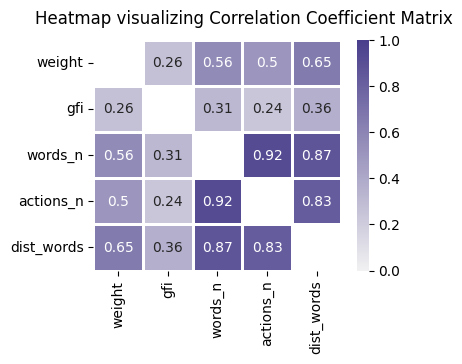

In [104]:
# Masking the diagonal cells   
masking = np.zeros_like(metrics_analisys, dtype = bool)  
np.fill_diagonal(masking, val = True)

# Generating a custom colormap
c_map = sns.light_palette("DarkSlateBlue", as_cmap=True)

# Print correlation heatmap
figure, axis = plt.subplots(figsize = (4, 3))
sns.heatmap(metrics_analisys, mask = masking, cmap = c_map, vmin = 0, vmax = 1, linewidths = 1, annot=True)  
figure.suptitle('Heatmap visualizing Correlation Coefficient Matrix', fontsize = 12)  
axis.tick_params(axis = 'both', which = 'major', labelsize = 10)  

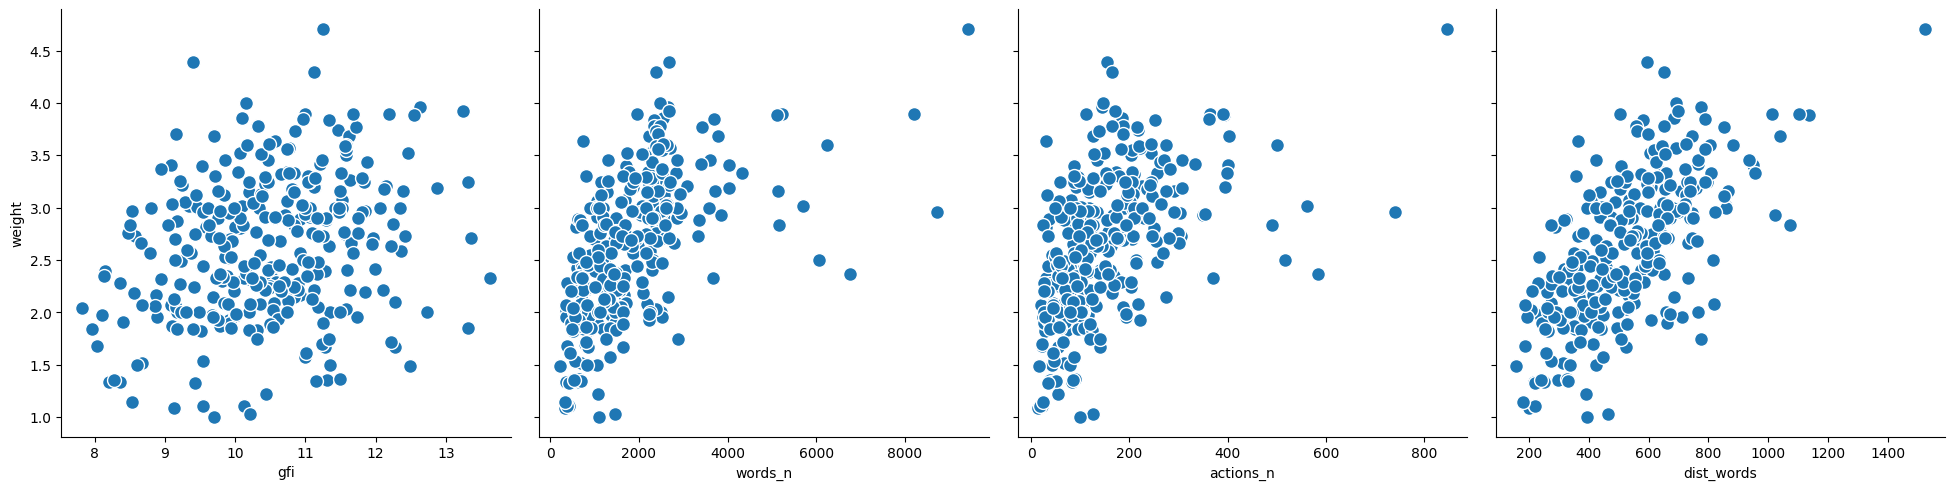

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.PairGrid(df, y_vars=["weight"], x_vars=['gfi', 'words_n', 'actions_n', 'dist_words'], height=5)
g.map(plt.scatter, s=100, edgecolor="white")

The dataframe and the plots printed above are useful to understand the correlation between the weight and the metrics computed by analisying the texts.
As can be seen, the syntactic complexity of the rules seems not to be directly correlated to the complexity of the game. Instead, the mother metrics seems to have a correlation, with the *number of distinct words* being the metric with the most direct correlation.

## **Linear Regression**

The idea is to use the 3 metrics that have a correlation with the weight to train a Linear Regression model in order to obtain a predictor of weight that simply use the texts of the rulebooks.

In [153]:
#Target
y = df['weight']

#Features
X = df[['words_n', 'dist_words', 'actions_n']]

In [176]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split

#Split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y.ravel(), test_size=0.25, random_state=6)

# Create linear regression object
#regr = linear_model.LinearRegression()
regr = linear_model.HuberRegressor() #robust to outliers

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))
# The root mean squared error
print("Root Mean squared error MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred, squared=False))
# The mean absolute error
print("Mean absolute error MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coeff of determination r2: %.2f" % metrics.r2_score(y_test, y_pred))

Mean squared error MSE: 0.21
Root Mean squared error MSE: 0.45
Mean absolute error MAE: 0.36
Coeff of determination r2: 0.60
